The files for MC and data come in the root format (see https://root.cern.ch in case you want more information). root is a powerful analysis framework widely used in particle physics. If you intend to get a final year project in particle physics, any time spent in learning a bit of it is time well spent. You may want to look at the examples using root and pyROOT if you want to do that. Otherwise uproot is a nice tool (https://uproot.readthedocs.io/en/latest/) to completely decouple from root and do your experiment with tools that you are familiar with.   

In [1]:
import uproot

The next line is needed to tell the code where the input files can be found.

In [2]:
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020"

You can actually inspect the URL above. You will see there are many directories, depending on the final state one wants to look at (2 leptons, 3 leptons, etc.). In this example we will focus on the 4 lepton processes.


In [3]:
final_state = "4lep"

Please look into the 4lep directory, you will see two further directories: "Data" and "MC". "Data" contains real collisions with four leptons. "MC" contains simulated collisions. For the "MC" directory you will see that several files are there, containing different physics processes. The following lines allow opening the root file. We open a random file for the moment. Please refer to the experiment handbook to understand the physics part of the project. Please be patient. Depending on your connection and on your hardware, this can take a bit. You can also download the files locally if your connection isn't too good. 

In [4]:
fileString = tuple_path+ '/' +  final_state + "/MC/mc_363490.llll.4lep.root"
mc = uproot.open(fileString)["mini"]
nEvents = uproot.numentries(fileString, "mini")
print ("There are ", nEvents, " events in file ", fileString)

There are  554279  events in file  https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/mc_363490.llll.4lep.root


Each event in the object named "mc" corresponds to a proton-proton collision event. For each event there are a number of numerical properties attached, that can be used to, e.g., select only events that one wants, combine variables to obtain new variables, etc. Let's print what are the properties that are available. Since the list is not short, to avoid cluttering the output, only variables containing the string "lep" in the name are printed. Please remove the filter if you want to see all variables. The 'b' in front of the name just tells you that the object is a variable. For those that want to know more, 'b' stands for 'branch': that is the original name in ROOT.

In [5]:
def filter_lep(name):
    if str(name).find("lep") > 0:
        return True
    return False

for event_variable in mc.keys(filtername=filter_lep):
    print(event_variable)

b'lep_n'
b'lep_truthMatched'
b'lep_trigMatched'
b'lep_pt'
b'lep_eta'
b'lep_phi'
b'lep_E'
b'lep_z0'
b'lep_charge'
b'lep_type'
b'lep_isTightID'
b'lep_ptcone30'
b'lep_etcone20'
b'lep_trackd0pvunbiased'
b'lep_tracksigd0pvunbiased'
b'lep_pt_syst'


Now let's reduce the number of events to those that have four or more leptons, and let's ask that the pt of all four leading leptons is larger than 20 GeV. Note that the units in the root file are MeV. First we may prepare some selection function:

In [6]:
def cut_nlep(nlep):
    return nlep < 4
def cut_ptlep(lep_pt):
    return lep_pt[0] < 20000 or lep_pt[1] < 20000 or lep_pt[2] < 20000 or lep_pt[3] < 20000

Next we loop over our events and apply the selection. We will be working on the variables lep_n and lep_pt for the selection, and we wll need mcWeight, scalefactor_* to compute MC event weights. See the handbook to understand the need for the event weights a bit better.

In [55]:
#### we use pandas as output of the "iterate" call

import pandas as pd
import numpy as np

# Let's create an empty DataFrame that will contain the events surviving the selection

my_sel_events = pd.DataFrame()

#### This will compute the total weight. In a similar way you can add any other variable to the DataFrame

def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_LepTRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

#### This will store the eta of the first lepton for plotting later

def eta_l1(eta_lep):
    return eta_lep[0]

for myevents in mc.iterate(["lep_n","lep_pt","lep_eta","mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_LepTRIGGER"], flatten=False, entrysteps=2500000, outputtype=pd.DataFrame, entrystop=nEvents):
    # we add a variable to the DataFrame
    myevents['totalWeight'] = np.vectorize(calc_weight)(myevents.mcWeight,myevents.scaleFactor_PILEUP,myevents.scaleFactor_ELE,myevents.scaleFactor_MUON,myevents.scaleFactor_LepTRIGGER)    
    myevents['lep1_eta'] = np.vectorize(eta_l1)(myevents.lep_eta)

### now we don't need part of the information any longer, let's drop it

    myevents.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_LepTRIGGER"], axis=1, inplace=True)

##### Now we apply our cuts and drop events accordingly

    fail=myevents[ np.vectorize(cut_nlep)(myevents.lep_n)].index
    myevents.drop(fail, inplace=True)
    
    fail=myevents[ np.vectorize(cut_ptlep)(myevents.lep_pt)].index
    myevents.drop(fail, inplace=True)
    
    my_sel_events = my_sel_events.append(myevents)




Let's now plot the leading lepton pseudorapidity. The histogram will be from -3 to 3, in bins with a 0.2 width, so a total of 30 bins. The "round" instructions is just to avoid numerical precision issues (e.g. -1.99999999999 instead of -2)

Now onto plotting 

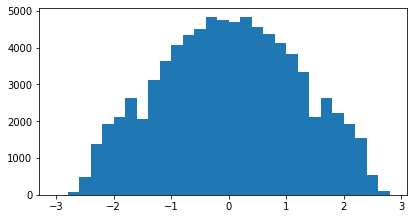

In [67]:
bins = [round(-3 + x*0.2,2) for x in range(0,30) ]
import matplotlib.pyplot as plt
plt.clf()
plt.axes([0.1,0.3,0.85,0.65]) #(left, bottom, width, height)
main_axes = plt.gca()
mc_heights = main_axes.hist(my_sel_events['lep1_eta'].values,bins=bins,weights=my_sel_events.totalWeight.values, label="my histogram")